In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def funcao_objetivo_grid(dobs,vp,vs,xe,ye,x0,y0):
    
    if vp <= vs:
        raise ValueError('vp deve ser maior que vs')
    
    if xe.size != ye.size:
        raise ValueError('xe e ye devem ter o mesmo numero de \
                         elementos')
    
    if (vp != 0.) & (vs != 0.):
        alfa = 1./vs - 1./vp
    else:
        raise ValueError('vp e vs devem ser diferentes de zero')
   
    phi = np.zeros_like(x0)
    for x, y, dt in zip(xe, ye, dobs):
        phi += (dt - alfa*np.sqrt((x - x0)**2 + (y - y0)**2))**2
    return phi

def dado(vp,vs,xe,ye,p):
    '''
    input
    vp: float
    vs: float
    xe: numpy array
    ye: numpy array
    p: numpy array
    
    output
    dt: numpy array
    '''
    
    if vp <= vs:
        raise ValueError('vp deve ser maior que vs')
    
    if xe.size != ye.size:
        raise ValueError('xe e ye devem ter o mesmo numero de \
                         elementos')
    
    if (vp != 0.) & (vs != 0.):
        alfa = 1./vs - 1./vp
    else:
        raise ValueError('vp e vs devem ser diferentes de zero')
    
    return alfa*np.sqrt((xe - p[0])**2 + (ye - p[1])**2)

def jacobiana(vp,vs,xe,ye,p):

    if vp <= vs:
        raise ValueError('vp deve ser maior que vs')
    
    if xe.size != ye.size:
        raise ValueError('xe e ye devem ter o mesmo numero de \
                         elementos')
    
    if (vp != 0.) & (vs != 0.):
        alfa = 1./vs - 1./vp
    else:
        raise ValueError('vp e vs devem ser diferentes de zero')

    N = xe.size
    M = p.size
    
    G = np.zeros((N,M))
    
    a1 = xe[:,0] - p[0,0]
    a2 = ye[:,0] - p[1,0]
    a3 = -alfa/((a1**2 + a2**2)**1.5)
    G[:,0] = a1*a3
    G[:,1] = a2*a3
    
    return G

def phi_val(dobs,d):
    r = dobs - d
    return np.sum(r*r)

def convergencia(phi0,phi,beta):
    variacao_rel = abs((phi0-phi)/phi0) 
    return variacao_rel < beta

In [3]:
xmin = 0.
xmax = 100.
ymin = -50.
ymax = 50.

Nx = 200
Ny = 200

In [4]:
vp = 6.5
vs = 6.5/1.6

In [5]:
p_verdadeiro = np.array([[50.],
                         [0.]])

In [6]:
xe = np.array([[10.],
               [80.],
               [7.]])

ye = np.array([[-40.],
               [0.],
               [35.]])

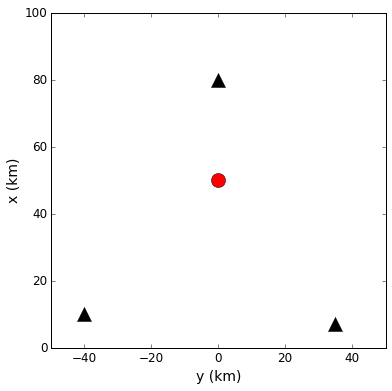

In [18]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.plot(ye,xe,'k^', markersize=14)
plt.plot([p_verdadeiro[1]], [p_verdadeiro[0]], 'ro', markersize=14)
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

In [8]:
dobs = dado(vp, vs, xe, ye, p_verdadeiro)

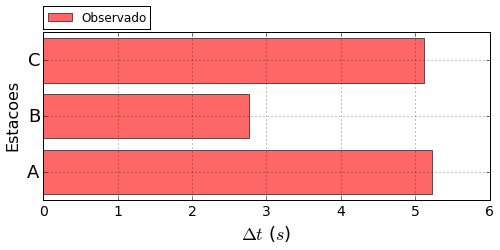

In [17]:
plt.figure(figsize=(8,3))
estacoes_label = ['A', 'B', 'C']
estacoes = [1,2,3]

plt.barh(estacoes, dobs, align='center', 
         color='r', alpha=0.6, label='Observado')
plt.yticks(estacoes, estacoes_label, fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\Delta t$ ($s$)', fontsize=18)
plt.ylabel('Estacoes', fontsize=16)
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=3, ncol=2, borderaxespad=0.)
plt.show()

In [10]:
xe_grid = np.linspace(xmin, xmax, Nx)
ye_grid = np.linspace(ymin, ymax, Ny)

xe_grid, ye_grid = np.meshgrid(xe_grid,ye_grid)

In [11]:
phi_grid = funcao_objetivo_grid(dobs,vp,vs,xe,ye,xe_grid,ye_grid)

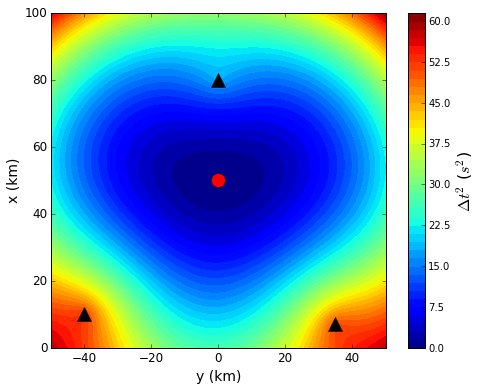

In [12]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.contourf(ye_grid,xe_grid,phi_grid,40)
cbar = plt.colorbar()
cbar.set_label('$\Delta t^{2}$ ($s^{2}$)', fontsize=16)
plt.plot(ye,xe,'k^', markersize=14)
plt.plot([p_verdadeiro[1]], [p_verdadeiro[0]], 'ro', markersize=14)
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

In [13]:
pinicial = np.array([[90.],
                     [-40.]])
itmax = 50
p0 = pinicial.copy()
d0 = dado(vp,vs,xe,ye,p0)
phi0 = phi_val(dobs,d0)
x0 = [p0[0,0]]
y0 = [p0[1,0]]
phi_list = [phi0]

beta = 0.001

I = np.identity(2)

lamb0 = 0.001
dlamb = 5.
itmax_marq = 15

lamb = lamb0

for it in range(itmax):
    
    G = jacobiana(vp,vs,xe,ye,p0)
   
    g = -2.*np.dot(G.T,(dobs - d0))
    H = 2.*np.dot(G.T,G)

    for it_marq in range(itmax_marq):
    
        dp = np.linalg.solve((H + lamb*I),-g)
    
        d = dado(vp,vs,xe,ye,p0+dp)
        phi = phi_val(dobs,d)
        
        dphi = phi - phi0
        
        if (dphi > 0.):
            lamb *= dlamb
        else:
            lamb /= dlamb
            break
    
    if convergencia(phi0,phi,beta):
        break
    else:
        phi0 = phi
        p0 += dp
        d0 = d
        x0.append(p0[0,0])
        y0.append(p0[1,0])
        phi_list.append(phi0)

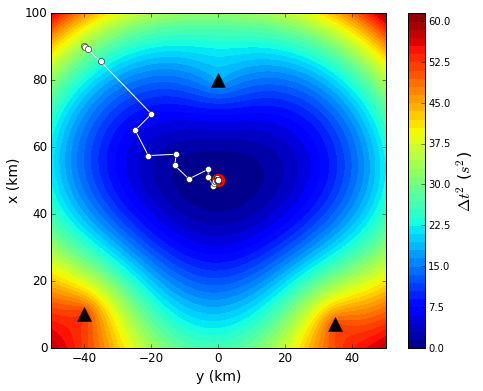

In [14]:
plt.figure(figsize=(8,6))
plt.axis('scaled')
plt.contourf(ye_grid,xe_grid,phi_grid,40)
cbar = plt.colorbar()
cbar.set_label('$\Delta t^{2}$ ($s^{2}$)', fontsize=16)
plt.plot(ye,xe,'k^', markersize=14)
plt.plot([p_verdadeiro[1]], [p_verdadeiro[0]], 'ro', markersize=14)
plt.plot(y0,x0,'w-', linewidth=1)
plt.plot(y0,x0,'wo', markersize=6)
plt.xlabel('y (km)', fontsize=14)
plt.ylabel('x (km)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(ymin,ymax)
plt.ylim(xmin,xmax)
plt.show()

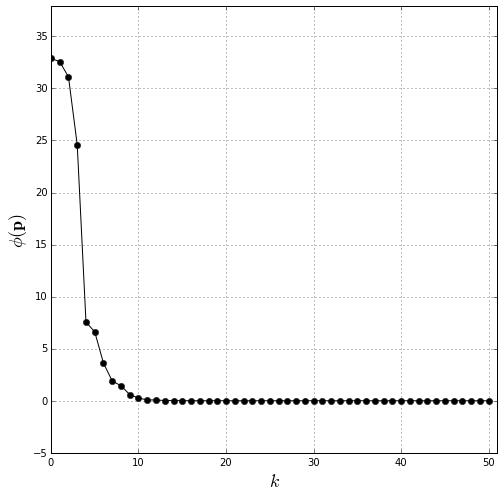

In [15]:
it = [i for i in range(len(phi_list))]
plt.figure(figsize=(8,8))
plt.plot(it,phi_list,'ko')
plt.plot(it,phi_list,'k-')
plt.xlabel('$k$', fontsize=18)
plt.ylabel('$\phi(\mathbf{p})$', fontsize=18)
plt.grid()
plt.xlim(0, len(phi_list))
plt.ylim(-5.,phi_list[0]+5.)
plt.show()

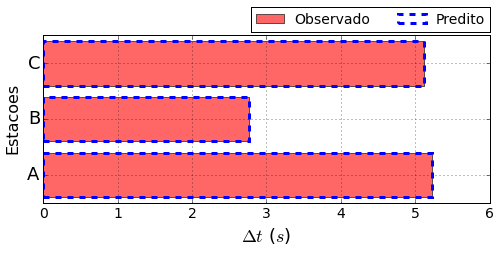

In [16]:
plt.figure(figsize=(8,3))
estacoes_label = ['A', 'B', 'C']
estacoes = [1,2,3]

plt.barh(estacoes, dobs, align='center', 
         color='r', alpha=0.6, label='Observado')
plt.barh(estacoes, d, align='center', 
         fill=False, edgecolor='b', alpha=1.,
         linewidth=3., linestyle='dashed', label='Predito')
plt.yticks(estacoes, estacoes_label, fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('$\Delta t$ ($s$)', fontsize=18)
plt.ylabel('Estacoes', fontsize=16)
plt.grid()
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), 
           loc=4, ncol=2, borderaxespad=0.,
           fontsize=14)
plt.show()